In [80]:
import cv2
import os
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
from scipy import ndimage
%matplotlib inline

In [111]:
from os import listdir
from os.path import isfile, join


get_image_filepaths = lambda dirpath: [os.path.join(dirpath, f) for f in listdir(dirpath) if isfile(join(dirpath, f)) and (f.endswith(".jpg") or f.endswith(".png"))]

In [82]:
def get_median_area(sorted_contours, numcards):
    return np.mean([cv2.contourArea(contour) for contour in sorted_contours[:numcards]])


def filter_contours(contours, median_area, tolerance = 2.0):
    n = len(contours)
    areas = [cv2.contourArea(contour) for contour in contours]
    return [
        contours[i] for i in range(n)
        if median_area / tolerance < areas[i] and areas[i] < median_area * tolerance
    ]

In [83]:
def filled_shape(img):
    kernel = np.ones((5,5),np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Smoothing without removing edges.
    gray_filtered = cv2.bilateralFilter(gray, 7, 50, 50)

    # Applying the canny filter
    edges_filtered = cv2.Canny(gray_filtered, 60, 120)
    mask = cv2.inRange(edges_filtered, 100, 255)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    filled = np.array(ndimage.binary_fill_holes(mask).astype(int),np.uint8)
    return filled

def num_shapes(img):
    filled = filled_shape(img)
    contours, _ = cv2.findContours(filled,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = [contour for contour in sorted(contours, key=cv2.contourArea,reverse=True) if cv2.contourArea(contour) < 400 **2]
    contours = filter_contours(contours, cv2.contourArea(contours[0]), 2.0)
    crops = []
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        # get crop
        crops.append(img[y:y+h, x:x+w])
    return len(contours), crops

In [84]:
templates = {}
directory = "../images/shapes"
new_img_dir = "../images/templates"
for img_filepath in get_image_filepaths(directory):
    print(img_filepath)
    filename = os.path.basename(img_filepath)
    img = cv2.imread(img_filepath)
    _, crops = num_shapes(img)
    new_path = os.path.join(new_img_dir, filename)
    cv2.imwrite(new_path, crops[0])

../images/shapes/green-single-stripes-squiggle.jpg
../images/shapes/green-single-stripes-diamond.jpg
../images/shapes/green-single-outline-capsule.jpg
../images/shapes/green-single-solid-capsule.jpg
../images/shapes/green-single-solid-squiggle.jpg
../images/shapes/green-single-outline-squiggle.jpg
../images/shapes/green-single-outline-diamond.jpg
../images/shapes/green-single-stripes-capsule.jpg
../images/shapes/green-single-solid-diamond.jpg


In [139]:
# try template matching
def filtered_edges(img):
    modified_sample_image = cv2.addWeighted(img, 4, cv2.blur(img, (30, 30)), -4, 128)
    gray = cv2.cvtColor(modified_sample_image, cv2.COLOR_BGR2GRAY)

    # Smoothing without removing edges.
    gray_filtered = cv2.bilateralFilter(gray, 7, 50, 50)

    # Applying the canny filter
    edges_filtered = cv2.Canny(gray_filtered, 60, 120)
    return edges_filtered

def get_templates(template_dir):
    return [filtered_edges(cv2.imread(im_path))
            for im_path in get_image_filepaths(template_dir)]
    
def best_template(img_rgb, templates):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    scores = [
        (template, np.max(cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)))
        for template in templates
    ]
    return max(scores, key=lambda pair: pair[1])

0.19793826


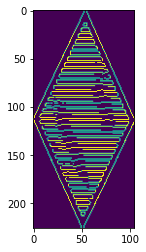

In [140]:
templates = get_templates("../images/templates")
sample_image = cv2.imread("../images/examples/three_diamond_solid_purple.png")
x = best_template(sample_image, templates)
print(x[1])
plt.imshow(x[0])

In [100]:
kernel = np.array([[-1,-1,-1], [2,2,2], [-1,-1,-1]])
modified_sample_image = cv2.addWeighted(sample_image, 4, cv2.blur(sample_image, (30, 30)), -4, 128)
gray = cv2.cvtColor(modified_sample_imagse, cv2.COLOR_BGR2GRAY)

# Smoothing without removing edges.
gray_filtered = cv2.bilateralFilter(gray, 7, 50, 50)

# Applying the canny filter
edges_filtered = cv2.Canny(gray_filtered, 60, 120)
# plt.imshow(modified_sample_image)
plt.imshow(edges_filtered)

NameError: name 'modified_sample_imagse' is not defined

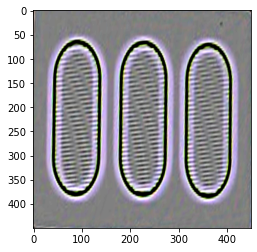

In [73]:
plt.imshow(cv2.addWeighted(sample_image, 4, cv2.blur(sample_image, (30, 30)), -4, 128))

In [131]:
HORIZONTAL_IMAGEPATH = "../images/horizontal_templates/horizontal_template.png"
horizontal_template = cv2.cvtColor(cv2.imread(HORIZONTAL_IMAGEPATH), cv2.COLOR_BGR2GRAY) 

def has_horizontal_lines(img_rgb, horizontal_template=horizontal_template):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    img_gray_sobel = cv2.Sobel(img_gray,cv2.CV_64F,0,1,ksize=5)
    horiz_template_sobel = cv2.Sobel(horizontal_template,cv2.CV_64F,0,1,ksize=5)
    
    print(np.shape(img_gray_sobel))
    print(np.shape(horiz_template_sobel))
    score = np.max(cv2.matchTemplate(img_gray_sobel,horiz_template_sobel,cv2.TM_CCOEFF_NORMED))
    return score

In [132]:

for imagepath in get_image_filepaths("../images/examples"):
    
    img = cv2.imread(imagepath)
    print(imagepath, has_horizontal_lines(img))
    print()

(450, 450)
(196, 74)


error: OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-tnokoph3/opencv/modules/imgproc/src/templmatch.cpp:1163: error: (-215:Assertion failed) (depth == CV_8U || depth == CV_32F) && type == _templ.type() && _img.dims() <= 2 in function 'matchTemplate'


In [110]:
print(get_image_filepaths("../images/examples"))

[]


In [210]:
import math

def contains_horizontal_lines(img_rgb, num_shapes=2, threshold_per=15):
    modified_sample_image = cv2.addWeighted(img_rgb, 4, cv2.blur(img, (30, 30)), -4, 128)
    gray = cv2.cvtColor(modified_sample_image, cv2.COLOR_BGR2GRAY)

    # Smoothing without removing edges.
    gray_filtered = cv2.bilateralFilter(gray, 7, 50, 50)

    # Applying the canny filter
    edges_filtered = cv2.Canny(gray_filtered, 60, 120)
    lines = cv2.HoughLinesP(edges_filtered, 1, math.pi/2, 2, None, 30, 1);
    try:
        return int(len(lines) / float(num_shapes)) > threshold_per
    except TypeError:
        return False
    

In [211]:

for imagepath in get_image_filepaths("../images/examples"):
    
    img = cv2.imread(imagepath)
    number, _ = num_shapes(img)
    print(imagepath, isolate_horizontal_lines(img, number))

../images/examples/one_squiggle_open_green.png False
../images/examples/one_diamond_striped_red.png False
../images/examples/one_squiggle_open_purple.png False
../images/examples/two_oval_solid_red.png False
../images/examples/two_oval_striped_green.png True
../images/examples/two_squiggle_open_green.png False
../images/examples/two_squiggle_open_red.png False
../images/examples/three_diamond_solid_purple.png False
../images/examples/three_oval_striped_green.png False
../images/examples/two_diamond_striped_green.png True
../images/examples/three_oval_striped_red.png True
../images/examples/one_diamond_striped_green.png False
